In [259]:
import pandas as pd
import numpy as np
import sys
sys.path.append("/home/mizworski/Repos/xgboost/python-package/")
sys.path.append("/home/mizworski/Repos/LightGBM/python-package/")
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.utils.validation import column_or_1d
from scipy import interp
from scipy import stats

In [216]:
import mlens
import lightgbm as lgb

In [364]:
df = pd.read_csv('../data/bank-classification.csv', index_col=0)
df = df.sample(frac=1)
df.head()

,job,marital,education,default,housing,loan,contact_date,contact,campaign,pdays,previous,poutcome,y,age,contact_weekday
id,,,,,,,,,,,,,,,
23457,technician,single,university.degree,no,no,no,2008-08-13,cellular,5,999,0,nonexistent,unknown,32,2
25744,management,married,professional.course,no,yes,no,2008-11-12,cellular,1,999,0,nonexistent,unknown,42,2
35520,entrepreneur,divorced,university.degree,no,yes,no,2009-05-25,telephone,1,999,0,nonexistent,no,45,0
40985,services,married,high.school,no,no,no,2010-10-18,cellular,3,999,0,nonexistent,unknown,44,0
20286,admin.,single,university.degree,no,no,yes,2008-08-04,cellular,3,999,0,nonexistent,no,36,0


In [365]:

df['education_bas'] = df['education'].isin(['4y', '9y', '6y'])
df.head()

,job,marital,education,default,housing,loan,contact_date,contact,campaign,pdays,previous,poutcome,y,age,contact_weekday,education_bas
id,,,,,,,,,,,,,,,,
23457,technician,single,university.degree,no,no,no,2008-08-13,cellular,5,999,0,nonexistent,unknown,32,2,False
25744,management,married,professional.course,no,yes,no,2008-11-12,cellular,1,999,0,nonexistent,unknown,42,2,False
35520,entrepreneur,divorced,university.degree,no,yes,no,2009-05-25,telephone,1,999,0,nonexistent,no,45,0,False
40985,services,married,high.school,no,no,no,2010-10-18,cellular,3,999,0,nonexistent,unknown,44,0,False
20286,admin.,single,university.degree,no,no,yes,2008-08-04,cellular,3,999,0,nonexistent,no,36,0,False


In [217]:
date_parse_format = '%Y-%m-%d'

def preprocess_data(data):
    now = datetime.strptime(data.contact_date.max(), date_parse_format)
#     data['sum_nan'] = (data[['default', 'loan', 'education', 'housing', 'job']] == 'unknown').sum(axis=1)

    data['age'] = data.apply(lambda r: 
                             int((now - datetime.strptime(r.birth_date, date_parse_format)).days / 365.0), 
                             axis=1)
    data.drop('birth_date', axis=1, inplace=True)
    
    data['contact_weekday'] = data.apply(lambda r: 
                                         (datetime.strptime(r.contact_date, date_parse_format)).weekday(), 
                                         axis=1)
    
#     data['education_bas'] = 1 if data['education'].isin(['9y', '6y']) else 0
    
    categorical_cols = list(set(data.columns) - 
                            set(['birth_date', 'contact_date', 'pdays', 'campaign', 'y','age', 'sum_nan']))
    X = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
#     X['contacted'] = pd.get_dummies(X.pdays < 999, drop_first=True)
    
    X['days_since_contact'] =  X.apply(lambda r: 
                                       int((now - datetime.strptime(r.contact_date, date_parse_format)).days), 
                                       axis=1)
    
    X.drop('contact_date', axis=1, inplace=True)
    
    train_x = X[X.y != 'unknown']
    test_x = X[X.y == 'unknown']
    train_y = train_x['y']
    train_y = pd.get_dummies(train_y, drop_first=True)
    train_x = train_x.drop('y', axis=1)
    test_x = test_x.drop('y', axis=1)
    
#     train_y = column_or_1d(train_y)
#     train_x = train_x.as_matrix()
#     test_x = test_x.as_matrix()
    
    return train_x, train_y, test_x
    

In [218]:

X_train, Y_train, X_test = preprocess_data(df)

from sklearn.model_selection import RandomizedSearchCV
from numpy import random
from sklearn.preprocessing import PolynomialFeatures

In [219]:
from mlens.ensemble import Subsemble

In [328]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import  LogisticRegression, LinearRegression


In [356]:
def get_ensemble():
    model1 = XGBClassifier(max_depth=4, gamma=3, reg_alpha=0.2137, min_child_weight=2, n_estimators=880,
                      reg_lambda=1, subsample=1, max_delta_step=5, learning_rate=0.006)

    model2 = lgb.LGBMClassifier(nthread=4,silent=False, bagging_fraction= 0.6, bagging_freq= 16,
                                boosting_type= 'dart',colsample_bytree= 0.9,feature_fraction= 0.7,
                                is_unbalance= False)
    model2b = lgb.LGBMClassifier(nthread=4,silent=False, bagging_fraction= 0.6, bagging_freq= 16,
                                boosting_type= 'dart',colsample_bytree= 0.9,feature_fraction= 0.7,
                                is_unbalance= False)

    model3 = GradientBoostingClassifier(n_estimators=100)
    model4 = RandomForestClassifier(n_estimators=100)
    model5 = lgb.LGBMClassifier(nthread=4,silent=False)
    model6 = XGBClassifier()
    model7 = LogisticRegression()
    ensemble = Subsemble()

#     # # First layer
    ensemble.add([model1, model2, model3], proba=True)
#     ensemble.add([LinearRegression() for i in range(6)])
#     ensemble.add([LinearRegression() for i in range(6)])
#     # # Second layer
#     ensemble.add([model3, model4], proba=True, shuffle=True)

    # # Final meta estimator
    ensemble.add_meta(LogisticRegression(), proba=True)
    
    return ensemble

In [357]:
# def get_ensemble2():
#     model1 = XGBRegressor(max_depth=4, gamma=3, reg_alpha=0.2137, min_child_weight=2, n_estimators=880,
#                       reg_lambda=1, subsample=1, max_delta_step=5, learning_rate=0.006)

#     model2 = lgb.LGBMRegressor(nthread=4,silent=False, bagging_fraction= 0.6, bagging_freq= 16,
#                                 boosting_type= 'dart',colsample_bytree= 0.9,feature_fraction= 0.7,
#                                 is_unbalance= False)

#     model3 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05)
#     model4 = RandomForestRegressor(n_estimators=100)
    
#     model5 = lgb.LGBMClassifier(nthread=4,silent=False)
#     model6 = XGBClassifier()
#     model7 = LogisticRegression()
#     ensemble = Subsemble()

# #     # # First layer
#     ensemble.add([model1, model2])

# #     # # Second layer
# #     ensemble.add([model3, model4], proba=True, shuffle=True)

#     # # Final meta estimator
#     ensemble.add_meta(model7, proba=True)
    
#     return ensemble

In [358]:
# ensemble = get_ensemble()

# Train ensemble
# ensemble.fit(X, Y)

In [359]:
# ensemble.predict(X[test])

In [360]:
cv = StratifiedKFold(n_splits=5)

X = X_train.as_matrix()
Y = column_or_1d(Y_train)

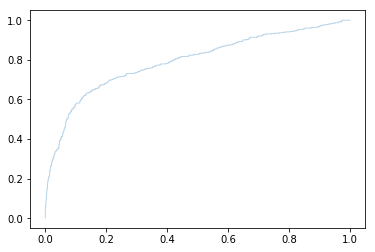

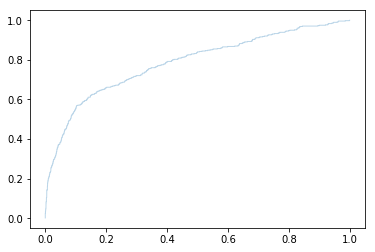

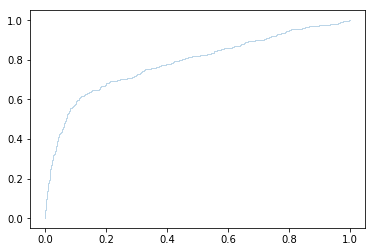

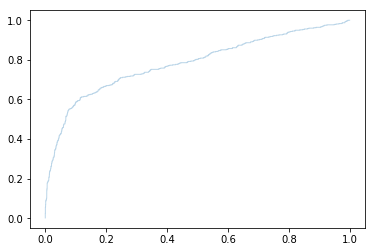

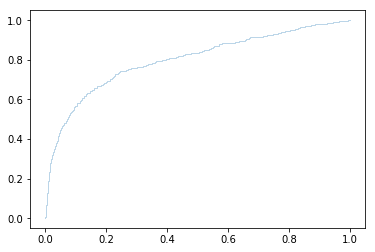

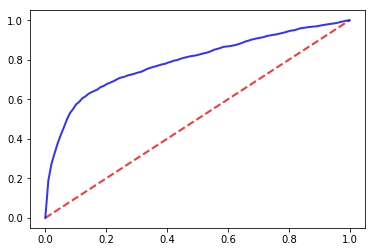

In [361]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i=0

for train, test in cv.split(X, Y):
    ensemble = get_ensemble()
    
    probas_ = ensemble.fit(X[train], Y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    plt.show()

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

plt.show()

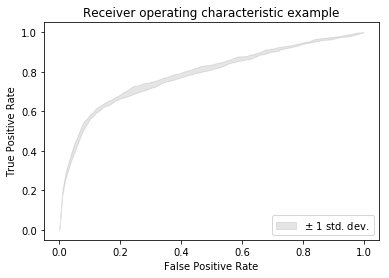

0.78986503692386045

In [362]:
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

mean_auc